# Equality Constrained Convex Quadratic Program Solvers

## Imports

In [ ]:
#!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [6]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import splu, spsolve
import casadi as ca
from casadi import *
import matplotlib.pyplot as plt
import scikits

ModuleNotFoundError: No module named 'scikits'

# Problem 1.3

The Goal here is to find x and y which solve the KKT matrix algebra problem:


$ \begin{bmatrix} H & -A \\ -A^T & 0 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} -g \\ -b \end{bmatrix} $

This formulation is slightly different from what can be found on page 451 of the texbook. There are the following differences:    
* We define $A$ as the transpose of the textbook's definition: $A_{report} = A^T_{texbook}$
* We have some different variable names: $H_{report} = G_{textbook}$, and $g_{report} = c_{textbook}$
* We have a negative sign in from of the bottom left $A$ matrix, and in front of $b$.
    
    - This is permissible since $-Ax = -b$ implies $Ax = b$ and vice versa (that is to say, we are solving for the same $x$ and $y$).

    - This is required since we need the KKT matrix to be symmetric for factorization.                   

## Dense LU Factorization

In [8]:
def EqualityQPSolveLUdense(H,g,A,b):

    _, Am = A.shape #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    KKT = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]])
    L, U = sp.linalg.lu(KKT, permute_l = True)
    vec = -np.concatenate([g, b], axis=0) 
    midd = np.linalg.solve(L, vec)
    out_vec = np.linalg.solve(U, midd)

    xout = out_vec[:len(g)]
    yout = out_vec[len(g):]
    
    return xout, yout

## Sparse LU Factorization

In [9]:
def EqualityQPSolveLUsparse(H,g,A,b):

    _, Am = A.shape #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    KKT = sp.sparse.csc_matrix(np.block([[H, -A],[-A.T,np.zeros([Am,Am])]])) #define the KKT matrix as a csc matrix
    LUsparse= splu(KKT) # the sparse lu function from scipy uses csc matrices. This produces an object with a .solve function
    vec = -np.concatenate([g, b], axis=0)
    out_vec = LUsparse.solve(vec) #using the .solve functionality to get the solution

    xout = out_vec[:len(g)]
    yout = out_vec[len(g):]
    
    return xout, yout

## Dense LDL.T Factorization

In [10]:
def EqualityQPSolveLDLdense(H,g,A,b):

    _, Am = A.shape 
    KKT = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]]) #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    L, D, perm = sp.linalg.ldl(KKT) #scipy's linalg.ldl performs a dense LDL.T decomposition
    vec = -np.concatenate([g, b], axis=0) 
    midd1 = np.linalg.solve(L, vec) #here we solve the system using the LDL.T factorization
    midd2 = np.linalg.solve(D, midd1)
    out_vec = np.linalg.solve(L.T, midd2) 
    xout = out_vec[:len(g)]
    yout = out_vec[len(g):]
    
    return xout, yout

## Sparse LDL.T Factorization

In [ ]:
def EqualityQPSolveLDLdense(H,g,A,b):

    _, Am = A.shape 
    KKT = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]]) #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    
    L, D, perm = sp.linalg.ldl(KKT) #scipy's linalg.ldl performs a dense LDL.T decomposition
    vec = -np.concatenate([g, b], axis=0) 
    midd1 = np.linalg.solve(L, vec) #here we solve the system using the LDL.T factorization
    midd2 = np.linalg.solve(D, midd1)
    out_vec = np.linalg.solve(L.T, midd2) 
    xout = out_vec[:len(g)]
    yout = out_vec[len(g):]
    
    return xout, yout

# Problem 1.6
In this section we solve a provided test question using one of our QP solvers, and compare the solution which Casadi finds.

## Defining the Test Problem

In [23]:
#Defining the test problem for 1.6
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])


g = np.array([
    [-16.1000],
    [-8.5000],
    [-15.7000],
    [-10.0200],
    [-18.6800]
])

A = np.array([
    [16.1000, 1.0000],
    [8.5000, 1.0000],
    [15.7000, 1.0000],
    [10.0200, 1.0000],
    [18.6800, 1.0000]
])


b = np.array([
    [15],
    [1]
])

<h3>Casadi<h3>

In [18]:
#We need a converter to get to Casadi formatting
def QP_Convert_To_Casadi(Hin, gin, Ain, bin): #This function accepts H, g, A, and b, and outputs Casadi's inputs

    # Convert all arrays to CASADI types first
    Hout = ca.SX(Hin)
    gout = ca.SX(gin)

    # Build constraint matrix
    Aout = ca.SX(Ain.T)


    # Build bounds
    lbg = ca.DM(bin)
    ubg = ca.DM(bin)
    
    Hn, _ = Hin.shape
    lbx = ca.DM(np.full((1, Hn), -np.inf))
    ubx = ca.DM(np.full((1, Hn),  np.inf))
        
    return Hout, gout, Aout, lbx, ubx, lbg, ubg

In [19]:
#This function accepts H, g, A, and b, and returns the Casadi solution
def Casadi_EC_QP(Hin,gin,Ain,bin): #This function accepts the same initial data that our solver accepts, and then returns the Casadi solution.
    nh, _ = Hin.shape
        
    H, g, A, lbx_, ubx_, lbg_, ubg_ = QP_Convert_To_Casadi(Hin,gin,Ain,bin)

    #print("H shape:", H.shape)
    #print("g shape:",g.shape)
    #print("A shape:", A.shape)
    #print("lbg shape:", lbg_.shape)
    #print("ubg shape:", ubg_.shape)

    # Define symbolic decision variable
    x = ca.SX.sym('x', nh) 

    # Objective: minimize 0.5 * x^T H x + g^T x
    objective = 0.5 * ca.dot(x, ca.mtimes(H, x)) + ca.dot(g, x)

    # Constraint: 
    constraint = ca.mtimes(A, x)

    # Define the QP in symbolic form
    qp = {
        'x': x,       # decision variables
        'f': objective,
        'g': constraint
    }

    # Create solver
    solver = ca.qpsol('S', 'qpoases', qp)

    # Call solver with bounds (symbolic part already defined)
    sol = solver(
        lbx=lbx_, 
        ubx=ubx_,  
        lbg=lbg_,   # 
        ubg=ubg_  #   
    )

    return sol['x']

## Solving the Test Problem

In [21]:
#First we solve the test problem with one of our solvers:
x, y = EqualityQPSolveLUdense(H,g,A,b)
print("x:\n",x.T,"\ny:\n",y.T)

#Next we do so with Casadi

Casadi_EC_QP(H,g,A,b)

x:
 [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]] 
y:
 [[-0.94962455  0.80823969]]

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See t

DM([0.150208, 0.140033, 0.354349, 0.0936457, 0.261765])

## Comparison

Our dense LDL solver finds:

x = [0.15020779, 0.1400325, 0.35434944, 0.09364569, 0.26176457]

Casadi finds:

x = [0.150208, 0.140033, 0.354349, 0.0936457, 0.261765]

These solutions are satisfactorily similar.

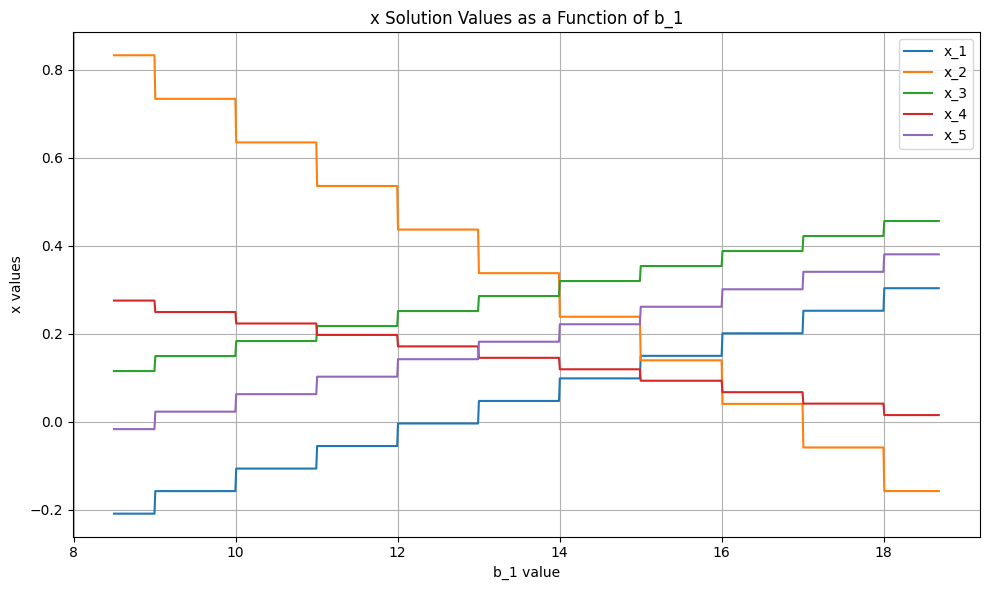

In [36]:
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])


g = np.array([
    [-16.1000],
    [-8.5000],
    [-15.7000],
    [-10.0200],
    [-18.6800]
])

A = np.array([
    [16.1000, 1.0000],
    [8.5000, 1.0000],
    [15.7000, 1.0000],
    [10.0200, 1.0000],
    [18.6800, 1.0000]
])


b = np.array([
    [15],
    [1]
])

bn = 1000
b1_space = np.linspace(8.50,18.68,bn)
xsol_matrix = np.zeros((bn,5))

for b_id in range(len(b1_space)):
    b[0,0]=b1_space[b_id]
    xsol, _ = EqualityQPSolveLUdense(H,g,A,b)
    xsol_matrix[b_id,:] = xsol.flatten()



plt.figure(figsize=(10, 6))
for i in range(xsol_matrix.shape[1]):
    plt.plot(b1_space, xsol_matrix[:, i], label=f'x_{i + 1}')

plt.xlabel('b_1 value')
plt.ylabel('x values')
plt.title('x Solution Values as a Function of b_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
